In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy
from steric_free_simulator import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver

EnergyExplorer Module is not available. Check Rosetta installation. <ipykernel.iostream.OutStream object at 0x7f80ef25c128>


In [2]:
base_input = '../../input_files/trimer_coup.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()

['A']
['B']
['C']
-----
{'A'}
{'A'}
set()
-----
{'A'}
{'B'}
{'A'}
False
Allowed edges: 
('A', 'B')
Connected Nodes:  ['A', 'B']
Connected Edges:  [('A', 'B')]
Allowed edges: 
('A', 'C')
Allowed edges: 
('B', 'C')
New node added--1
['A', 'B']
{('A', 'B'): [None, None, 1, tensor([-20000.], dtype=torch.float64)], ('A', 'C'): [None, None, 1, tensor([-20000.], dtype=torch.float64)], ('B', 'C'): [None, None, 1, tensor([-20000.], dtype=torch.float64)]}
New node added--2
[0, 1, 2, 3]
-----
{'A'}
{'C'}
{'A'}
False
Allowed edges: 
('A', 'B')
Allowed edges: 
('A', 'C')
Connected Nodes:  ['A', 'C']
Connected Edges:  [('A', 'C')]
Allowed edges: 
('B', 'C')
New node added--1
['A', 'C']
{('A', 'B'): [None, None, 1, tensor([-20000.], dtype=torch.float64)], ('A', 'C'): [None, None, 1, tensor([-20000.], dtype=torch.float64)], ('B', 'C'): [None, None, 1, tensor([-20000.], dtype=torch.float64)]}
New node added--2
[0, 1, 2, 3, 4]
Allowed edges: 
('A', 'B')
Allowed edges: 
('A', 'C')
Allowed edges: 
('B', '

In [3]:
uid_dict = {}
sys.path.append("../../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(uid_dict)

{(0, 3): 0, (0, 4): 1, (0, 6): 5, (1, 3): 0, (1, 5): 2, (1, 6): 3, (2, 4): 1, (2, 5): 2, (2, 6): 4, (3, 6): 4, (4, 6): 3, (5, 6): 5}


In [4]:
sys.path.append("../../")
import numpy as np
from reaction_network import gtostr
from torch import DoubleTensor as Tensor
import torch

node_map = {}
for node in rn.network.nodes():
    node_map[gtostr(rn.network.nodes[node]['struct'])] = node
def get_max_edge(vec_rn,n,node_map):
    """
    Calculates the max rate (k_on) for a given node
    To find out the maximum flow path to the final complex starting from the current node.
    
    Can also calculate the total rate of consumption of a node by summing up all rates. 
    Can tell which component is used quickly.
    """
    try:
        edges = rn.network.out_edges(n)
        #Loop over all edges
        #Get attributes
        if len(edges)==0:
            return(False)
        kon_max = -1
        next_node = -1
        
        kon_sum = 0
        for edge in edges:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']
            #Get updated kon
            temp_kon = vec_rn.kon[uid]
            kon_sum+=temp_kon
            
            if temp_kon > kon_max:
                kon_max = temp_kon
                next_node=edge[1]
        return(kon_max,next_node,kon_sum)
    except Exception as err:
        raise(err)
def get_node_flux(vec_rn,n):
    total_flux_outedges = 0
    total_flux_inedges = 0
    #Go over all the out edges
    edges_out = rn.network.out_edges(n)
    if len(edges_out)>0:

        for edge in edges_out:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]

            #Calculate k_off also
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Getting conc. of reactants and products
            #Get product
            prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

            #Net flux from this edge = Generation - consumption
            edge_flux = koff*vec_rn.copies_vec[edge[1]] - temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])
            #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

#             print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
#             print("Net flux: ",edge_flux)
#             print("kon : ",temp_kon)
#             print("koff: ",koff)
#             print("Reaction data OUTWARD: ")
#             print(data)

            total_flux_outedges+=edge_flux
    
    #Now go over all the in edges
    edges_in = rn.network.in_edges(n)
    react_list = []
    if len(edges_in) > 0:
        for edge in edges_in:
            if edge[0] in react_list:
                continue
            data = rn.network.get_edge_data(edge[0],edge[1])
            uid = data['uid']


            #Get generation rates; which would be kon
            temp_kon = vec_rn.kon[uid]

            #Get consumption rates; which is k_off
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Get conc. of reactants and products
            prod = gtostr(rn.network.nodes[edge[1]]['struct'])
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
            react_list.append(node_map[react])
            #Net flux from this edge = Generation - consumption
            edge_flux_in = temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])- koff*vec_rn.copies_vec[edge[1]]
            #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


#             print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
#             print("Net flux: ",edge_flux_in)
#             print("kon : ",temp_kon)
#             print("koff: ",koff)
#             print("Raction data INWARD: ")
#             print(data)

            total_flux_inedges+=edge_flux_in
    net_node_flux = total_flux_outedges + total_flux_inedges
    
    return(net_node_flux)

def do_flux_analysis(vec_rn,node_map):
    pathway = []
    kon_sumarray = []
    total_con_rate = {}
    net_flux = {}
    for n in rn.network.nodes():

        n_str = gtostr(rn.network.nodes[n]['struct']) 

        paths = [n_str]
        kon_sum = 0
        temp_node = n
        max_edge = True
        consumption_rate = 0
        if n < len(rn.network.nodes()):#num_monomers:
    #         print("Current node: ")
    #         print(n_str)
            while max_edge:
                max_edge = get_max_edge(vec_rn,temp_node,node_map)
                if max_edge:
                    total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                    temp_node = max_edge[1]
                    kon_sum += max_edge[0].item()


    #                 print("Next node: ")
    #                 print(temp_node)

                    paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
                else:
                    break
            pathway.append(paths)
            kon_sumarray.append(kon_sum)
            paths=[]
            
        net_flux[gtostr(rn.network.nodes[n]['struct'])] = get_node_flux(vec_rn,n)

    #print(pathway)
    #print(kon_sumarray)
    
    return(total_con_rate,net_flux)

In [5]:
## Changing Initial Conditions
import networkx as nx
#Changin k_on
kon_list = [1.0,10.0]# uM-1 s-1

final_yield = {kon : [] for kon in kon_list}
optimized_rates = {kon : [] for kon in kon_list}
observables = {kon : dict() for kon in kon_list} 
flux_data = {kon : [] for kon in kon_list}
cons_data = {kon : [] for kon in kon_list}
final_copies = {kon : [] for kon in kon_list}

for new_kon in kon_list:

    nx.set_edge_attributes(rn.network,new_kon,'k_on')
    
    
    vec_rn = VectorizedRxnNet(rn, dev='cpu',coupling=True,cid={1:0,2:0})
    vec_rn.reset(reset_params=True)
    
    ### Start Optimization
    print("Running Optimization with the following on rates: ")
    print(vec_rn.kon)
    optim = Optimizer(reaction_network=vec_rn,
                      sim_runtime=1,
                      optim_iterations=10000,
                      learning_rate=new_kon/10000,
                      device='cpu')
    optim.rn.update_reaction_net(rn)
    optim.optimize()
    
    final_yield[new_kon] = optim.yield_per_iter
    optimized_rates[new_kon] = vec_rn.kon
    
    ###Run simulation with optimized parameters
    print("Running simulation with optimized parameters")
    optim_rn = optim.rn
    sim_times = [1,2,10]
    for i, runtime in enumerate(sim_times):
        optim_rn.reset()
        sim = VecSim(optim_rn, runtime, device='cpu')
        y = sim.simulate()
        
        observables[new_kon][runtime] = (sim.steps.copy(),sim.observables.copy())
        print("Length of observables: ", len(sim.observables[0][1]))
    
    ##Calculate the net flux in across each node/species
    print("Doing flux analysis")
    cons_rate,flux = do_flux_analysis(vec_rn,node_map)
    
    flux_data[new_kon].append(flux)
    cons_data[new_kon].append(cons_rate)
    final_copies[new_kon].append(vec_rn.copies_vec)
    
        
    

A
B
C
AB
AC
BC
ABC
Running Optimization with the following on rates: 
tensor([1., 1., 1., 1., 1., 1.], dtype=torch.float64, grad_fn=<CopySlices>)
Using CPU
Reaction Parameters before optimization: 
[Parameter containing:
tensor([1., 1., 1., 1.], dtype=torch.float64, requires_grad=True)]
Using CPU
Next time:  tensor(1.0606, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 0 was 49.7%
current params: tensor([1.0001, 1.0001, 1.0001, 1.0001], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0605, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1 was 49.7%
current params: tensor([1.0000, 1.0002, 1.0002, 1.0002], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0604, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2 was 49.7%
current params: tensor([0.9999, 1.0003, 1.0003, 1.0003], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0604, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 3 was 49.7%
current pa

Next time:  tensor(1.0581, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 41 was 49.8%
current params: tensor([0.9960, 1.0039, 1.0039, 1.0039], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0581, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 42 was 49.8%
current params: tensor([0.9959, 1.0039, 1.0040, 1.0040], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0580, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 43 was 49.8%
current params: tensor([0.9958, 1.0040, 1.0040, 1.0040], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0580, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 44 was 49.8%
current params: tensor([0.9957, 1.0041, 1.0041, 1.0041], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0579, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 45 was 49.9%
current params: tensor([0.9956, 1.0042, 1.0042, 1.0042], dtype=torch.float64)
Using CPU
Next time:  tensor(1

current params: tensor([0.9918, 1.0077, 1.0077, 1.0078], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0557, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 84 was 50.0%
current params: tensor([0.9917, 1.0078, 1.0078, 1.0079], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0556, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 85 was 50.0%
current params: tensor([0.9916, 1.0079, 1.0079, 1.0079], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0556, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 86 was 50.0%
current params: tensor([0.9915, 1.0080, 1.0080, 1.0080], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0555, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 87 was 50.0%
current params: tensor([0.9914, 1.0081, 1.0081, 1.0081], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0555, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 88 was 50.0%
current params: tens

Next time:  tensor(1.0534, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 126 was 50.2%
current params: tensor([0.9875, 1.0117, 1.0117, 1.0117], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0533, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 127 was 50.2%
current params: tensor([0.9874, 1.0118, 1.0118, 1.0118], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0533, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 128 was 50.2%
current params: tensor([0.9873, 1.0119, 1.0119, 1.0119], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0532, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 129 was 50.2%
current params: tensor([0.9872, 1.0120, 1.0120, 1.0120], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0532, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 130 was 50.2%
current params: tensor([0.9871, 1.0121, 1.0121, 1.0121], dtype=torch.float64)
Using CPU
Next time:  ten

Next time:  tensor(1.0511, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 168 was 50.3%
current params: tensor([0.9832, 1.0156, 1.0156, 1.0156], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0510, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 169 was 50.3%
current params: tensor([0.9831, 1.0157, 1.0157, 1.0157], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0510, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 170 was 50.3%
current params: tensor([0.9830, 1.0157, 1.0157, 1.0157], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0509, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 171 was 50.3%
current params: tensor([0.9829, 1.0158, 1.0158, 1.0158], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0509, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 172 was 50.3%
current params: tensor([0.9828, 1.0159, 1.0159, 1.0159], dtype=torch.float64)
Using CPU
Next time:  ten

current params: tensor([0.9790, 1.0194, 1.0194, 1.0194], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0488, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 211 was 50.5%
current params: tensor([0.9789, 1.0195, 1.0195, 1.0195], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0488, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 212 was 50.5%
current params: tensor([0.9788, 1.0196, 1.0196, 1.0196], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0487, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 213 was 50.5%
current params: tensor([0.9787, 1.0197, 1.0197, 1.0197], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0486, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 214 was 50.5%
current params: tensor([0.9786, 1.0198, 1.0198, 1.0197], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0486, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 215 was 50.5%
current params:

current params: tensor([0.9748, 1.0232, 1.0232, 1.0232], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0466, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 253 was 50.6%
current params: tensor([0.9747, 1.0233, 1.0233, 1.0233], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0465, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 254 was 50.6%
current params: tensor([0.9746, 1.0234, 1.0234, 1.0234], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0465, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 255 was 50.6%
current params: tensor([0.9745, 1.0235, 1.0235, 1.0235], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0465, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 256 was 50.6%
current params: tensor([0.9743, 1.0236, 1.0236, 1.0236], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0464, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 257 was 50.6%
current params:

current params: tensor([0.9705, 1.0270, 1.0271, 1.0270], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0445, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 295 was 50.8%
current params: tensor([0.9704, 1.0271, 1.0271, 1.0271], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0444, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 296 was 50.8%
current params: tensor([0.9703, 1.0272, 1.0272, 1.0272], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0444, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 297 was 50.8%
current params: tensor([0.9702, 1.0273, 1.0273, 1.0273], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0443, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 298 was 50.8%
current params: tensor([0.9701, 1.0274, 1.0274, 1.0274], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0443, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 299 was 50.8%
current params:

current params: tensor([0.9661, 1.0309, 1.0309, 1.0309], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0423, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 338 was 50.9%
current params: tensor([0.9660, 1.0310, 1.0310, 1.0310], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0423, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 339 was 50.9%
current params: tensor([0.9659, 1.0311, 1.0311, 1.0311], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0423, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 340 was 50.9%
current params: tensor([0.9658, 1.0312, 1.0312, 1.0312], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0422, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 341 was 50.9%
current params: tensor([0.9657, 1.0313, 1.0313, 1.0313], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0422, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 342 was 50.9%
current params:

current params: tensor([0.9619, 1.0347, 1.0347, 1.0347], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0403, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 380 was 51.1%
current params: tensor([0.9618, 1.0348, 1.0348, 1.0348], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0403, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 381 was 51.1%
current params: tensor([0.9617, 1.0349, 1.0349, 1.0349], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0402, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 382 was 51.1%
current params: tensor([0.9616, 1.0350, 1.0350, 1.0350], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0402, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 383 was 51.1%
current params: tensor([0.9615, 1.0351, 1.0351, 1.0351], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0401, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 384 was 51.1%
current params:

current params: tensor([0.9575, 1.0386, 1.0386, 1.0386], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0383, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 423 was 51.2%
current params: tensor([0.9574, 1.0387, 1.0387, 1.0387], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0382, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 424 was 51.2%
current params: tensor([0.9573, 1.0388, 1.0388, 1.0388], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0382, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 425 was 51.3%
current params: tensor([0.9572, 1.0389, 1.0389, 1.0389], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0381, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 426 was 51.3%
current params: tensor([0.9571, 1.0390, 1.0390, 1.0390], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0381, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 427 was 51.3%
current params:

current params: tensor([0.9532, 1.0424, 1.0424, 1.0424], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0363, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 465 was 51.4%
current params: tensor([0.9531, 1.0425, 1.0425, 1.0425], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0363, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 466 was 51.4%
current params: tensor([0.9530, 1.0426, 1.0426, 1.0426], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0362, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 467 was 51.4%
current params: tensor([0.9529, 1.0427, 1.0427, 1.0426], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0362, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 468 was 51.4%
current params: tensor([0.9528, 1.0427, 1.0427, 1.0427], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0361, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 469 was 51.4%
current params:

current params: tensor([0.9490, 1.0462, 1.0461, 1.0461], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0344, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 507 was 51.6%
current params: tensor([0.9489, 1.0462, 1.0462, 1.0462], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0344, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 508 was 51.6%
current params: tensor([0.9487, 1.0463, 1.0463, 1.0463], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0343, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 509 was 51.6%
current params: tensor([0.9486, 1.0464, 1.0464, 1.0464], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0343, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 510 was 51.6%
current params: tensor([0.9485, 1.0465, 1.0465, 1.0465], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0342, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 511 was 51.6%
current params:

Next time:  tensor(1.0326, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 549 was 51.7%
current params: tensor([0.9446, 1.0500, 1.0500, 1.0500], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0325, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 550 was 51.7%
current params: tensor([0.9445, 1.0501, 1.0501, 1.0501], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0325, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 551 was 51.7%
current params: tensor([0.9444, 1.0502, 1.0502, 1.0502], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0324, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 552 was 51.7%
current params: tensor([0.9443, 1.0503, 1.0503, 1.0503], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0324, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 553 was 51.7%
current params: tensor([0.9442, 1.0504, 1.0504, 1.0503], dtype=torch.float64)
Using CPU
Next time:  ten

Next time:  tensor(1.0307, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 591 was 51.9%
current params: tensor([0.9403, 1.0537, 1.0537, 1.0537], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0307, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 592 was 51.9%
current params: tensor([0.9402, 1.0538, 1.0538, 1.0538], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0306, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 593 was 51.9%
current params: tensor([0.9401, 1.0539, 1.0539, 1.0539], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0306, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 594 was 51.9%
current params: tensor([0.9400, 1.0540, 1.0540, 1.0540], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0306, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 595 was 51.9%
current params: tensor([0.9399, 1.0541, 1.0541, 1.0541], dtype=torch.float64)
Using CPU
Next time:  ten

Next time:  tensor(1.0290, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 633 was 52.0%
current params: tensor([0.9360, 1.0575, 1.0575, 1.0575], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0289, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 634 was 52.0%
current params: tensor([0.9359, 1.0576, 1.0576, 1.0576], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0289, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 635 was 52.0%
current params: tensor([0.9358, 1.0576, 1.0576, 1.0577], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0288, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 636 was 52.0%
current params: tensor([0.9357, 1.0577, 1.0577, 1.0577], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0288, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 637 was 52.0%
current params: tensor([0.9356, 1.0578, 1.0578, 1.0578], dtype=torch.float64)
Using CPU
Next time:  ten

Next time:  tensor(1.0272, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 675 was 52.2%
current params: tensor([0.9317, 1.0612, 1.0612, 1.0612], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0272, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 676 was 52.2%
current params: tensor([0.9316, 1.0613, 1.0613, 1.0613], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0271, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 677 was 52.2%
current params: tensor([0.9315, 1.0614, 1.0614, 1.0614], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0271, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 678 was 52.2%
current params: tensor([0.9313, 1.0615, 1.0615, 1.0615], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0271, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 679 was 52.2%
current params: tensor([0.9312, 1.0615, 1.0616, 1.0616], dtype=torch.float64)
Using CPU
Next time:  ten

Next time:  tensor(1.0255, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 717 was 52.3%
current params: tensor([0.9273, 1.0649, 1.0649, 1.0649], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0255, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 718 was 52.3%
current params: tensor([0.9272, 1.0650, 1.0650, 1.0650], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0255, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 719 was 52.3%
current params: tensor([0.9271, 1.0651, 1.0651, 1.0651], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0254, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 720 was 52.3%
current params: tensor([0.9270, 1.0652, 1.0652, 1.0652], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0254, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 721 was 52.3%
current params: tensor([0.9269, 1.0653, 1.0653, 1.0653], dtype=torch.float64)
Using CPU
Next time:  ten

current params: tensor([0.9230, 1.0686, 1.0686, 1.0686], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0239, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 760 was 52.5%
current params: tensor([0.9229, 1.0687, 1.0687, 1.0687], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0238, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 761 was 52.5%
current params: tensor([0.9228, 1.0688, 1.0688, 1.0688], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0238, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 762 was 52.5%
current params: tensor([0.9227, 1.0689, 1.0689, 1.0689], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0237, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 763 was 52.5%
current params: tensor([0.9226, 1.0690, 1.0690, 1.0690], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0237, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 764 was 52.5%
current params:

current params: tensor([0.9187, 1.0723, 1.0723, 1.0723], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0222, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 802 was 52.6%
current params: tensor([0.9186, 1.0724, 1.0724, 1.0724], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0222, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 803 was 52.6%
current params: tensor([0.9185, 1.0725, 1.0725, 1.0725], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0222, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 804 was 52.6%
current params: tensor([0.9184, 1.0726, 1.0726, 1.0726], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0221, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 805 was 52.6%
current params: tensor([0.9183, 1.0727, 1.0727, 1.0727], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0221, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 806 was 52.6%
current params:

current params: tensor([0.9144, 1.0760, 1.0760, 1.0760], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0207, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 844 was 52.8%
current params: tensor([0.9143, 1.0761, 1.0761, 1.0761], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0206, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 845 was 52.8%
current params: tensor([0.9142, 1.0762, 1.0762, 1.0762], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0206, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 846 was 52.8%
current params: tensor([0.9141, 1.0763, 1.0763, 1.0763], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0206, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 847 was 52.8%
current params: tensor([0.9140, 1.0764, 1.0764, 1.0764], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0205, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 848 was 52.8%
current params:

current params: tensor([0.9100, 1.0797, 1.0797, 1.0797], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0191, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 886 was 52.9%
current params: tensor([0.9099, 1.0798, 1.0798, 1.0798], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0191, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 887 was 52.9%
current params: tensor([0.9098, 1.0799, 1.0799, 1.0799], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0190, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 888 was 53.0%
current params: tensor([0.9097, 1.0800, 1.0800, 1.0800], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0190, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 889 was 53.0%
current params: tensor([0.9096, 1.0801, 1.0801, 1.0801], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0190, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 890 was 53.0%
current params:

current params: tensor([0.9057, 1.0834, 1.0834, 1.0834], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0176, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 928 was 53.1%
current params: tensor([0.9056, 1.0835, 1.0835, 1.0835], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0176, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 929 was 53.1%
current params: tensor([0.9055, 1.0836, 1.0836, 1.0835], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0176, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 930 was 53.1%
current params: tensor([0.9054, 1.0836, 1.0837, 1.0836], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0175, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 931 was 53.1%
current params: tensor([0.9053, 1.0837, 1.0837, 1.0837], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0175, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 932 was 53.1%
current params:

current params: tensor([0.9013, 1.0871, 1.0871, 1.0870], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0162, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 970 was 53.3%
current params: tensor([0.9012, 1.0871, 1.0871, 1.0871], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0162, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 971 was 53.3%
current params: tensor([0.9011, 1.0872, 1.0872, 1.0872], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0161, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 972 was 53.3%
current params: tensor([0.9010, 1.0873, 1.0873, 1.0873], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0161, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 973 was 53.3%
current params: tensor([0.9009, 1.0874, 1.0874, 1.0874], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0161, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 974 was 53.3%
current params:

current params: tensor([0.8970, 1.0907, 1.0907, 1.0907], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0148, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1012 was 53.4%
current params: tensor([0.8969, 1.0908, 1.0908, 1.0908], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0147, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1013 was 53.4%
current params: tensor([0.8968, 1.0909, 1.0909, 1.0909], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0147, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1014 was 53.4%
current params: tensor([0.8967, 1.0910, 1.0910, 1.0910], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0147, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1015 was 53.4%
current params: tensor([0.8966, 1.0910, 1.0911, 1.0911], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0146, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1016 was 53.4%
current pa

current params: tensor([0.8926, 1.0944, 1.0944, 1.0944], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0134, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1054 was 53.6%
current params: tensor([0.8925, 1.0944, 1.0945, 1.0944], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0134, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1055 was 53.6%
current params: tensor([0.8924, 1.0945, 1.0945, 1.0945], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0133, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1056 was 53.6%
current params: tensor([0.8923, 1.0946, 1.0946, 1.0946], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0133, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1057 was 53.6%
current params: tensor([0.8922, 1.0947, 1.0947, 1.0947], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0133, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1058 was 53.6%
current pa

current params: tensor([0.8882, 1.0980, 1.0980, 1.0980], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0121, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1096 was 53.7%
current params: tensor([0.8881, 1.0981, 1.0981, 1.0981], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0120, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1097 was 53.7%
current params: tensor([0.8880, 1.0982, 1.0982, 1.0982], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0120, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1098 was 53.7%
current params: tensor([0.8879, 1.0983, 1.0983, 1.0983], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0120, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1099 was 53.7%
current params: tensor([0.8878, 1.0983, 1.0983, 1.0983], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0120, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1100 was 53.7%
current pa

current params: tensor([0.8839, 1.1016, 1.1016, 1.1016], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0108, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1138 was 53.9%
current params: tensor([0.8838, 1.1017, 1.1017, 1.1017], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0107, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1139 was 53.9%
current params: tensor([0.8837, 1.1018, 1.1018, 1.1018], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0107, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1140 was 53.9%
current params: tensor([0.8836, 1.1019, 1.1019, 1.1019], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0107, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1141 was 53.9%
current params: tensor([0.8834, 1.1020, 1.1020, 1.1020], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0107, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1142 was 53.9%
current pa

current params: tensor([0.8795, 1.1052, 1.1053, 1.1053], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0095, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1180 was 54.0%
current params: tensor([0.8794, 1.1053, 1.1054, 1.1054], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0095, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1181 was 54.0%
current params: tensor([0.8793, 1.1054, 1.1055, 1.1054], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0094, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1182 was 54.0%
current params: tensor([0.8792, 1.1055, 1.1055, 1.1055], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0094, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1183 was 54.0%
current params: tensor([0.8791, 1.1056, 1.1056, 1.1056], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0094, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1184 was 54.0%
current pa

current params: tensor([0.8751, 1.1089, 1.1089, 1.1089], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0083, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1222 was 54.2%
current params: tensor([0.8750, 1.1090, 1.1090, 1.1090], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0083, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1223 was 54.2%
current params: tensor([0.8749, 1.1091, 1.1091, 1.1091], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0082, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1224 was 54.2%
current params: tensor([0.8748, 1.1092, 1.1091, 1.1091], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0082, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1225 was 54.2%
current params: tensor([0.8747, 1.1092, 1.1092, 1.1092], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0082, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1226 was 54.2%
current pa

current params: tensor([0.8707, 1.1125, 1.1125, 1.1125], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0071, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1264 was 54.3%
current params: tensor([0.8706, 1.1126, 1.1126, 1.1126], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0071, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1265 was 54.3%
current params: tensor([0.8705, 1.1127, 1.1127, 1.1127], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0071, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1266 was 54.3%
current params: tensor([0.8704, 1.1128, 1.1128, 1.1128], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0070, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1267 was 54.3%
current params: tensor([0.8703, 1.1128, 1.1128, 1.1128], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0070, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1268 was 54.4%
current pa

current params: tensor([0.8663, 1.1161, 1.1161, 1.1161], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0060, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1306 was 54.5%
current params: tensor([0.8662, 1.1162, 1.1162, 1.1162], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0059, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1307 was 54.5%
current params: tensor([0.8661, 1.1163, 1.1163, 1.1163], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0059, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1308 was 54.5%
current params: tensor([0.8660, 1.1164, 1.1164, 1.1164], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0059, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1309 was 54.5%
current params: tensor([0.8659, 1.1164, 1.1164, 1.1164], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0059, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1310 was 54.5%
current pa

current params: tensor([0.8619, 1.1197, 1.1197, 1.1197], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0049, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1348 was 54.6%
current params: tensor([0.8618, 1.1198, 1.1198, 1.1198], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0048, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1349 was 54.6%
current params: tensor([0.8617, 1.1199, 1.1199, 1.1199], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0048, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1350 was 54.7%
current params: tensor([0.8616, 1.1200, 1.1200, 1.1200], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0048, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1351 was 54.7%
current params: tensor([0.8615, 1.1200, 1.1200, 1.1200], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0047, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1352 was 54.7%
current pa

current params: tensor([0.8575, 1.1233, 1.1233, 1.1233], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0038, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1390 was 54.8%
current params: tensor([0.8574, 1.1234, 1.1234, 1.1234], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0037, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1391 was 54.8%
current params: tensor([0.8573, 1.1234, 1.1235, 1.1235], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0037, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1392 was 54.8%
current params: tensor([0.8572, 1.1235, 1.1235, 1.1235], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0037, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1393 was 54.8%
current params: tensor([0.8571, 1.1236, 1.1236, 1.1236], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0037, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1394 was 54.8%
current pa

current params: tensor([0.8531, 1.1269, 1.1269, 1.1269], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0027, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1432 was 55.0%
current params: tensor([0.8530, 1.1270, 1.1270, 1.1269], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0027, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1433 was 55.0%
current params: tensor([0.8529, 1.1270, 1.1271, 1.1270], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0027, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1434 was 55.0%
current params: tensor([0.8528, 1.1271, 1.1271, 1.1271], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0026, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1435 was 55.0%
current params: tensor([0.8527, 1.1272, 1.1272, 1.1272], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0026, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1436 was 55.0%
current pa

current params: tensor([0.8487, 1.1305, 1.1304, 1.1305], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0017, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1474 was 55.1%
current params: tensor([0.8486, 1.1305, 1.1305, 1.1305], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0017, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1475 was 55.1%
current params: tensor([0.8485, 1.1306, 1.1306, 1.1306], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0017, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1476 was 55.1%
current params: tensor([0.8484, 1.1307, 1.1307, 1.1307], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0017, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1477 was 55.1%
current params: tensor([0.8483, 1.1308, 1.1308, 1.1308], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0016, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1478 was 55.1%
current pa

current params: tensor([0.8443, 1.1340, 1.1340, 1.1340], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0007, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1516 was 55.3%
current params: tensor([0.8441, 1.1341, 1.1341, 1.1341], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0007, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1517 was 55.3%
current params: tensor([0.8440, 1.1342, 1.1342, 1.1342], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0007, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1518 was 55.3%
current params: tensor([0.8439, 1.1343, 1.1343, 1.1343], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0007, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1519 was 55.3%
current params: tensor([0.8438, 1.1344, 1.1344, 1.1343], dtype=torch.float64)
Using CPU
Next time:  tensor(1.0007, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1520 was 55.3%
current pa

current params: tensor([0.8398, 1.1376, 1.1376, 1.1376], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1305, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1558 was 55.8%
current params: tensor([0.8397, 1.1377, 1.1377, 1.1377], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1305, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1559 was 55.8%
current params: tensor([0.8396, 1.1378, 1.1378, 1.1377], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1305, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1560 was 55.8%
current params: tensor([0.8395, 1.1378, 1.1378, 1.1378], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1305, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1561 was 55.8%
current params: tensor([0.8394, 1.1379, 1.1379, 1.1379], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1305, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1562 was 55.8%
current pa

current params: tensor([0.8353, 1.1412, 1.1412, 1.1412], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1297, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1600 was 55.9%
current params: tensor([0.8352, 1.1413, 1.1413, 1.1413], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1297, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1601 was 55.9%
current params: tensor([0.8351, 1.1414, 1.1414, 1.1414], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1296, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1602 was 55.9%
current params: tensor([0.8350, 1.1415, 1.1415, 1.1415], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1296, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1603 was 55.9%
current params: tensor([0.8349, 1.1415, 1.1415, 1.1416], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1296, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1604 was 55.9%
current pa

current params: tensor([0.8308, 1.1448, 1.1448, 1.1448], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1289, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1642 was 56.1%
current params: tensor([0.8307, 1.1449, 1.1449, 1.1449], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1289, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1643 was 56.1%
current params: tensor([0.8306, 1.1450, 1.1450, 1.1450], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1288, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1644 was 56.1%
current params: tensor([0.8305, 1.1451, 1.1451, 1.1451], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1288, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1645 was 56.1%
current params: tensor([0.8304, 1.1452, 1.1452, 1.1452], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1288, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1646 was 56.1%
current pa

current params: tensor([0.8263, 1.1485, 1.1485, 1.1484], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1281, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1684 was 56.3%
current params: tensor([0.8262, 1.1485, 1.1485, 1.1485], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1281, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1685 was 56.3%
current params: tensor([0.8260, 1.1486, 1.1486, 1.1486], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1281, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1686 was 56.3%
current params: tensor([0.8259, 1.1487, 1.1487, 1.1487], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1280, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1687 was 56.3%
current params: tensor([0.8258, 1.1488, 1.1488, 1.1488], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1280, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1688 was 56.3%
current pa

current params: tensor([0.8217, 1.1521, 1.1521, 1.1521], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1274, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1726 was 56.4%
current params: tensor([0.8216, 1.1521, 1.1522, 1.1522], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1273, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1727 was 56.4%
current params: tensor([0.8215, 1.1522, 1.1522, 1.1522], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1273, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1728 was 56.4%
current params: tensor([0.8214, 1.1523, 1.1523, 1.1523], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1273, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1729 was 56.4%
current params: tensor([0.8213, 1.1524, 1.1524, 1.1524], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1273, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1730 was 56.4%
current pa

current params: tensor([0.8172, 1.1557, 1.1557, 1.1557], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1267, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1768 was 56.6%
current params: tensor([0.8171, 1.1558, 1.1557, 1.1558], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1266, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1769 was 56.6%
current params: tensor([0.8170, 1.1558, 1.1558, 1.1559], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1266, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1770 was 56.6%
current params: tensor([0.8169, 1.1559, 1.1559, 1.1559], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1266, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1771 was 56.6%
current params: tensor([0.8168, 1.1560, 1.1560, 1.1560], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1266, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1772 was 56.6%
current pa

current params: tensor([0.8127, 1.1593, 1.1593, 1.1593], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1260, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1810 was 56.7%
current params: tensor([0.8126, 1.1593, 1.1594, 1.1594], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1260, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1811 was 56.7%
current params: tensor([0.8125, 1.1594, 1.1595, 1.1594], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1260, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1812 was 56.7%
current params: tensor([0.8124, 1.1595, 1.1595, 1.1595], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1260, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1813 was 56.8%
current params: tensor([0.8123, 1.1596, 1.1596, 1.1596], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1260, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1814 was 56.8%
current pa

current params: tensor([0.8082, 1.1629, 1.1629, 1.1629], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1254, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1852 was 56.9%
current params: tensor([0.8081, 1.1630, 1.1630, 1.1629], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1254, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1853 was 56.9%
current params: tensor([0.8080, 1.1630, 1.1630, 1.1630], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1254, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1854 was 56.9%
current params: tensor([0.8078, 1.1631, 1.1631, 1.1631], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1253, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1855 was 56.9%
current params: tensor([0.8077, 1.1632, 1.1632, 1.1632], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1253, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1856 was 56.9%
current pa

current params: tensor([0.8036, 1.1665, 1.1665, 1.1665], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1248, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1894 was 57.1%
current params: tensor([0.8035, 1.1666, 1.1665, 1.1665], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1248, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1895 was 57.1%
current params: tensor([0.8034, 1.1666, 1.1666, 1.1666], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1248, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1896 was 57.1%
current params: tensor([0.8033, 1.1667, 1.1667, 1.1667], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1248, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1897 was 57.1%
current params: tensor([0.8032, 1.1668, 1.1668, 1.1668], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1248, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1898 was 57.1%
current pa

current params: tensor([0.7991, 1.1701, 1.1700, 1.1700], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1243, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1936 was 57.2%
current params: tensor([0.7990, 1.1701, 1.1701, 1.1701], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1242, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1937 was 57.2%
current params: tensor([0.7989, 1.1702, 1.1702, 1.1702], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1242, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1938 was 57.2%
current params: tensor([0.7988, 1.1703, 1.1703, 1.1703], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1242, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1939 was 57.2%
current params: tensor([0.7987, 1.1704, 1.1704, 1.1704], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1242, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1940 was 57.2%
current pa

current params: tensor([0.7946, 1.1736, 1.1736, 1.1736], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1237, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1978 was 57.4%
current params: tensor([0.7945, 1.1737, 1.1737, 1.1737], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1237, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1979 was 57.4%
current params: tensor([0.7944, 1.1738, 1.1738, 1.1738], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1237, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1980 was 57.4%
current params: tensor([0.7943, 1.1739, 1.1739, 1.1739], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1237, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1981 was 57.4%
current params: tensor([0.7941, 1.1740, 1.1740, 1.1740], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1237, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 1982 was 57.4%
current pa

current params: tensor([0.7900, 1.1772, 1.1772, 1.1772], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1233, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2020 was 57.6%
current params: tensor([0.7899, 1.1773, 1.1773, 1.1773], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1232, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2021 was 57.6%
current params: tensor([0.7898, 1.1774, 1.1774, 1.1774], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1232, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2022 was 57.6%
current params: tensor([0.7897, 1.1775, 1.1775, 1.1775], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1232, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2023 was 57.6%
current params: tensor([0.7896, 1.1775, 1.1775, 1.1775], dtype=torch.float64)
Using CPU
Next time:  tensor(1.1232, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 2024 was 57.6%
current pa

Next time:  tensor(30.4326, dtype=torch.float64, grad_fn=<AddBackward0>)
yield on sim iteration 0 was 57.1%
current params: tensor([10.0010, 10.0010, 10.0010, 10.0010], dtype=torch.float64)
Killing optimization because too much RAM being used.
0.4553985595703125
Running simulation with optimized parameters
Using CPU
Next time:  tensor(30.4295, dtype=torch.float64, grad_fn=<AddBackward0>)
Length of observables:  51
Using CPU
Next time:  tensor(30.4295, dtype=torch.float64, grad_fn=<AddBackward0>)
Length of observables:  51
Using CPU
Next time:  tensor(30.4295, dtype=torch.float64, grad_fn=<AddBackward0>)
Length of observables:  51
Doing flux analysis


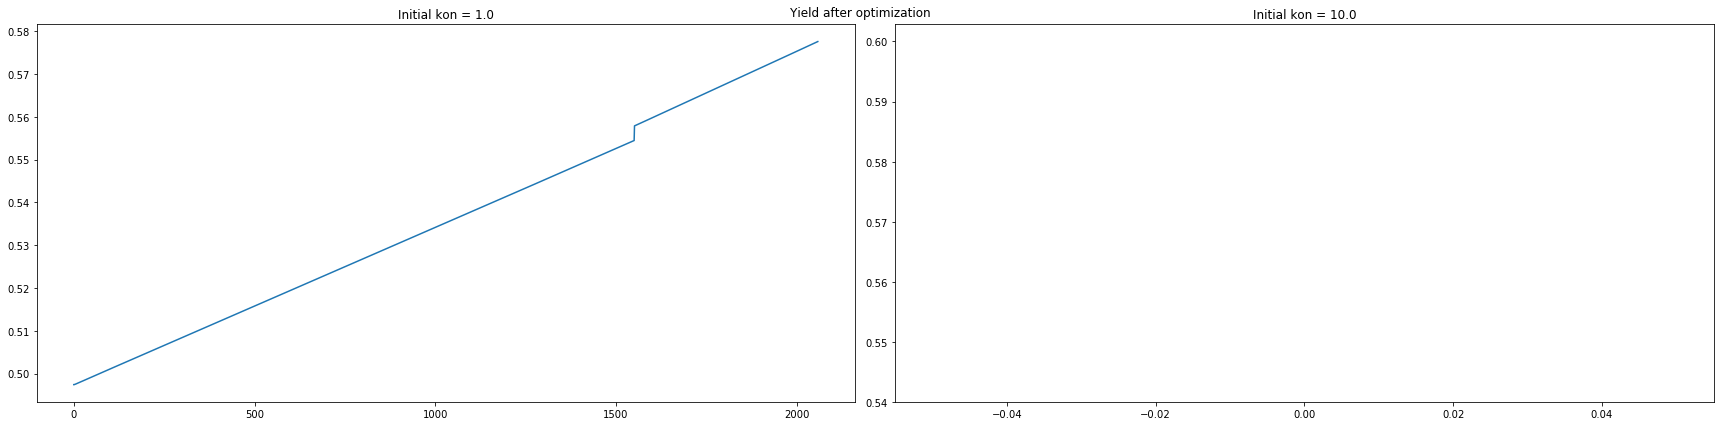

In [6]:
##Plotting yield for each optimized rates
from matplotlib import pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, len(kon_list))
i= 0
for kon,val in final_yield.items():
    ax[i].plot(val)
    ax[i].set_title("Initial kon = " + str(kon))
    i+=1
    

txt = fig.suptitle("Yield after optimization")
fig.set_size_inches(24, 6)
fig.tight_layout()
plt.show()

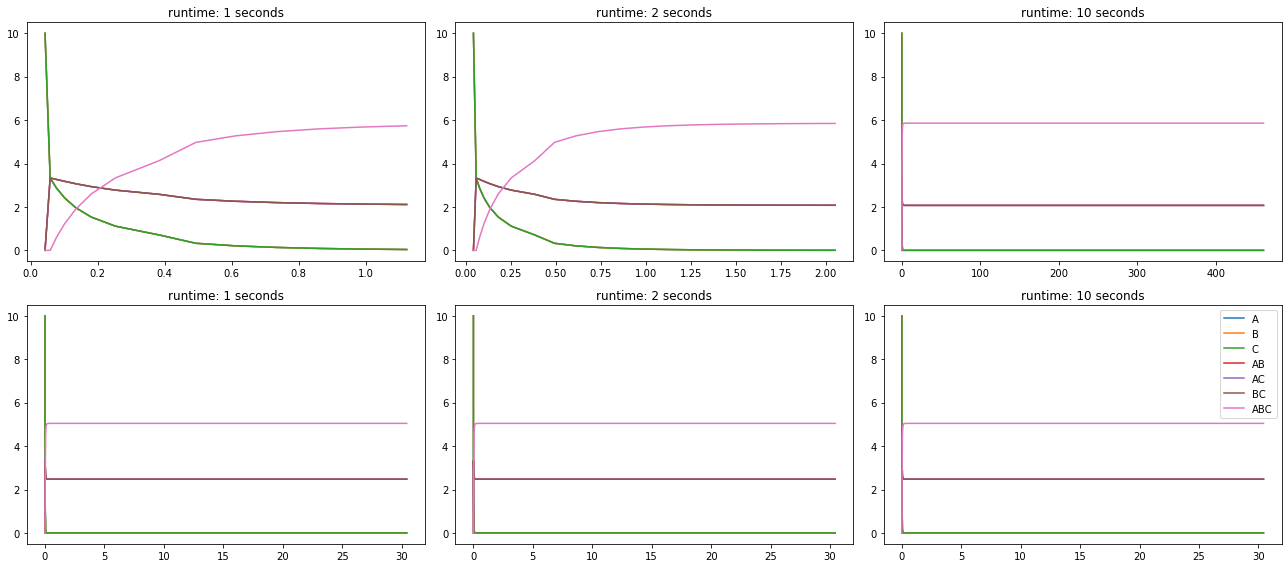

In [7]:
times = 3
fig,ax = plt.subplots(len(kon_list),times)
i=0
nodes_list = ['A','B','C','AB','BC','AC','ABC']
for kon,runtimes in observables.items():
    for time,val in runtimes.items():
        #print(time)
        for key in val[1].keys():
            if val[1][key][0] in nodes_list:
                row = int(i/times)
                col = i%times
                #print(val[1][key][1][:5])
                #print(len(val[1][key][1]))
                ax[row,col].plot(val[0],val[1][key][1],label=val[1][key][0])
        ax[row,col].set_title("runtime: " + str(time) + " seconds")
        i+=1
lgnd = plt.legend(loc='best')
fig.set_size_inches(18, 8)
fig.tight_layout()
plt.show()

In [8]:
print(int(4/4))

1


In [9]:
for kon,flux in flux_data.items():
    print("-----------------------")
    print("Starting on rate: ", kon)
    print("Final copies: ", final_copies[kon])
    print("Optimzied parameters: ", optimized_rates[kon])
    
    print("Flux: ")
    for k,v in sorted(flux[0].items(),key=lambda x : x[1]):
        print(k," : ", v)

-----------------------
Starting on rate:  1.0
Final copies:  [tensor([1.9631e-05, 1.9649e-05, 1.9661e-05, 1.7380e+00, 1.7380e+00, 1.7380e+00,
        6.5240e+00], dtype=torch.float64, grad_fn=<MaxBackward2>)]
Optimzied parameters:  tensor([0.7858, 0.7858, 0.7858, 1.1805, 1.1805, 1.1805], dtype=torch.float64,
       grad_fn=<CopySlices>)
Flux: 
AB  :  tensor([-0.0002], dtype=torch.float64, grad_fn=<AddBackward0>)
AC  :  tensor([-0.0002], dtype=torch.float64, grad_fn=<AddBackward0>)
BC  :  tensor([-0.0002], dtype=torch.float64, grad_fn=<AddBackward0>)
ABC  :  tensor([0.0001], dtype=torch.float64, grad_fn=<AddBackward0>)
C  :  tensor([0.0004], dtype=torch.float64, grad_fn=<AddBackward0>)
B  :  tensor([0.0004], dtype=torch.float64, grad_fn=<AddBackward0>)
A  :  tensor([0.0004], dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------
Starting on rate:  10.0
Final copies:  [tensor([2.9890e-05, 2.9890e-05, 2.9890e-05, 2.1429e+00, 2.1429e+00, 2.1429e+00,
        5.7141e+00], dtyp

In [5]:
#x = [3,4,5]
d = {3:[0,1]}
lis = [20,30,40,50]

n = max(lis[i] for i in d[3])
print(n)
print("MAx numeber for %s is chosen as %.2f" %(d,n))

30
MAx numeber for {3: [0, 1]} is chosen as 30.00


In [11]:
import numpy as np
k0 = np.array([ 1.0,  1.0, 1.0, 1.0, 1.0, 1.0])
kf = np.array([1.6677e-03, 2.1857e-02, 1.6281e-03, 1.7823e+00, 1.7024e+00, 1.7025e+00])

delta_k = kf/k0

delta_e = -np.log(delta_k)

print(delta_e)
print(np.sum(delta_e))

[ 6.39630985  3.82323404  6.42034159 -0.57790467 -0.53203902 -0.53209776]
14.997844033923245
